# 코로나 이후 매출 증감 여부 예측 모델
## 1. 패키지 준비하기

In [1]:
import sys
sys.path.append('../')
import helper

import numpy as np
import seaborn as sb
from pandas import read_excel, DataFrame, get_dummies
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

## 2. 데이터셋 준비하기

In [2]:
origin = read_excel('tdf.xlsx')
origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   상권_코드        1009 non-null   int64  
 1   상권_코드_명      1009 non-null   object 
 2   점포수_x        1009 non-null   float64
 3   도심_x         1009 non-null   int64  
 4   총_직장_인구_수_x  1009 non-null   float64
 5   총_생활인구_수_x   1009 non-null   float64
 6   점포수_y        1009 non-null   float64
 7   총_직장_인구_수_y  1009 non-null   int64  
 8   총_생활인구_수_y   1009 non-null   float64
 9   매출증감         1009 non-null   int64  
dtypes: float64(5), int64(4), object(1)
memory usage: 79.0+ KB


## 3. 데이터 전처리
### 1) 결측치 확인

In [3]:
origin.isna().sum()

상권_코드          0
상권_코드_명        0
점포수_x          0
도심_x           0
총_직장_인구_수_x    0
총_생활인구_수_x     0
점포수_y          0
총_직장_인구_수_y    0
총_생활인구_수_y     0
매출증감           0
dtype: int64

## 4. 탐색적 데이터 분석
> 앞 과정에서 이미 수행하였으므로 생략

## 5. 데이터셋 분할하기
### 1) 랜덤시드 고정

In [4]:
np.random.seed(777)

### 2) 훈련 데이터(독립변수)와 레이블(종속변수) 구분하기
- 이 때 형태에 주의! (Series or DataFrame)
    - Series로 넣을 경우 나중에 `DataFrame화` 하고 `.flatten() 함수`를 사용해야 됨 (모델을 학습하고 결과를 내는 과정에서)

In [5]:
x = origin.drop(['상권_코드', '상권_코드_명', '매출증감'], axis = 1)
x.head()
y = origin['매출증감']
y.head()

0    0
1    0
2    0
3    0
4    0
Name: 매출증감, dtype: int64

### 3) 데이터 표준화
- 명목형을 제거한 임시 데이터프레임 생성

In [6]:
tmp = x.drop('도심_x', axis=1)
tmp

,점포수_x,총_직장_인구_수_x,총_생활인구_수_x,점포수_y,총_직장_인구_수_y,총_생활인구_수_y
0,6.825688,21133.770642,1.063927e+06,6.564356,13700,1.108208e+06
1,4.519231,10343.230769,3.304633e+06,4.493333,11773,3.704169e+06
2,7.094340,43510.654088,2.169122e+06,7.382550,39506,1.775981e+06
3,4.418182,8267.454545,2.516156e+06,4.390000,1696,3.109088e+06
4,3.263158,2711.131579,3.022949e+05,3.417910,4252,4.745286e+05
...,...,...,...,...,...,...
1004,3.347826,1999.320652,4.004372e+06,3.603659,2122,5.776149e+06
1005,4.018072,4313.216867,7.342383e+05,4.311765,966,1.371762e+06
1006,5.335484,4582.309677,5.981897e+06,5.780303,2503,7.212605e+06
1007,4.771084,5432.831325,6.812592e+06,4.650685,6064,8.757489e+06


- 임시 데이터프레임을 활용하여 표준화

In [7]:
x_scaler = StandardScaler()
x_scale = x_scaler.fit_transform(tmp)
x_scale_df = DataFrame(x_scale, columns=tmp.columns, index=tmp.index)
x_scale_df

,점포수_x,총_직장_인구_수_x,총_생활인구_수_x,점포수_y,총_직장_인구_수_y,총_생활인구_수_y
0,1.466482,1.423805,-1.635368,1.082146,0.790915,-1.809769
1,0.114631,0.317615,-0.133935,-0.064296,0.578999,-0.461570
2,1.623943,3.717765,-0.894809,1.535069,3.628849,-1.462965
3,0.055405,0.104818,-0.662271,-0.121498,-0.529187,-0.770622
4,-0.621573,-0.464787,-2.145716,-0.659611,-0.248099,-2.138868
...,...,...,...,...,...,...
1004,-0.571948,-0.537758,0.334939,-0.556788,-0.482339,0.614503
1005,-0.179106,-0.300550,-1.856283,-0.164806,-0.609466,-1.672894
1006,0.593050,-0.272964,1.660022,0.648123,-0.440440,1.360518
1007,0.262246,-0.185773,2.216647,0.022808,-0.048830,2.162846


- 표준화 결과에 명목형 변수를 결합

In [8]:
x_scale_df['도심'] = x['도심_x']
x_scale_df

,점포수_x,총_직장_인구_수_x,총_생활인구_수_x,점포수_y,총_직장_인구_수_y,총_생활인구_수_y,도심
0,1.466482,1.423805,-1.635368,1.082146,0.790915,-1.809769,1
1,0.114631,0.317615,-0.133935,-0.064296,0.578999,-0.461570,1
2,1.623943,3.717765,-0.894809,1.535069,3.628849,-1.462965,1
3,0.055405,0.104818,-0.662271,-0.121498,-0.529187,-0.770622,1
4,-0.621573,-0.464787,-2.145716,-0.659611,-0.248099,-2.138868,1
...,...,...,...,...,...,...,...
1004,-0.571948,-0.537758,0.334939,-0.556788,-0.482339,0.614503,0
1005,-0.179106,-0.300550,-1.856283,-0.164806,-0.609466,-1.672894,0
1006,0.593050,-0.272964,1.660022,0.648123,-0.440440,1.360518,0
1007,0.262246,-0.185773,2.216647,0.022808,-0.048830,2.162846,0


### 4) 훈련 데이터와 검증 데이터로 분할

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x_scale_df,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=777)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((706, 7), (303, 7), (706,), (303,))

## 6. 모델 개발
### 1) 모델 정의

In [10]:
my_model = Sequential()
my_model.add(Dense(64, activation = 'relu', input_shape=(len(x_train.columns),)))
my_model.add(Dense(1, activation = 'sigmoid'))
my_model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics=['acc'])
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                512       
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 577 (2.25 KB)
Trainable params: 577 (2.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 2) 학습하기

In [11]:
result = my_model.fit(x_train, 
                      y_train, 
                      epochs = 500, 
                      validation_data=(x_test, y_test),
                      callbacks=[EarlyStopping(monitor='val_loss',
                                               patience=5,
                                               verbose=1),
                                 ReduceLROnPlateau(monitor='val_loss',
                                                   patience=3,
                                                   factor=0.5,
                                                   min_lr=0.0001,
                                                   verbose=1)])

Epoch 1/500


23/23 [==============================] - 0s 6ms/step - loss: 0.6957 - acc: 0.5340 - val_loss: 0.6894 - val_acc: 0.5182 - lr: 0.0010
Epoch 2/500
23/23 [==============================] - 0s 2ms/step - loss: 0.6879 - acc: 0.5524 - val_loss: 0.6897 - val_acc: 0.5182 - lr: 0.0010
Epoch 3/500
23/23 [==============================] - 0s 2ms/step - loss: 0.6859 - acc: 0.5552 - val_loss: 0.6908 - val_acc: 0.5215 - lr: 0.0010
Epoch 4/500
 1/23 [>.............................] - ETA: 0s - loss: 0.6633 - acc: 0.6250
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
23/23 [==============================] - 0s 2ms/step - loss: 0.6846 - acc: 0.5581 - val_loss: 0.6893 - val_acc: 0.5248 - lr: 0.0010
Epoch 5/500
23/23 [==============================] - 0s 2ms/step - loss: 0.6825 - acc: 0.5609 - val_loss: 0.6891 - val_acc: 0.5215 - lr: 5.0000e-04
Epoch 6/500
23/23 [==============================] - 0s 2ms/step - loss: 0.6819 - acc: 0.5637 - val_loss: 0.6896 - val_acc: 0.5215 - l

## 7. 학습결과 평가

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning

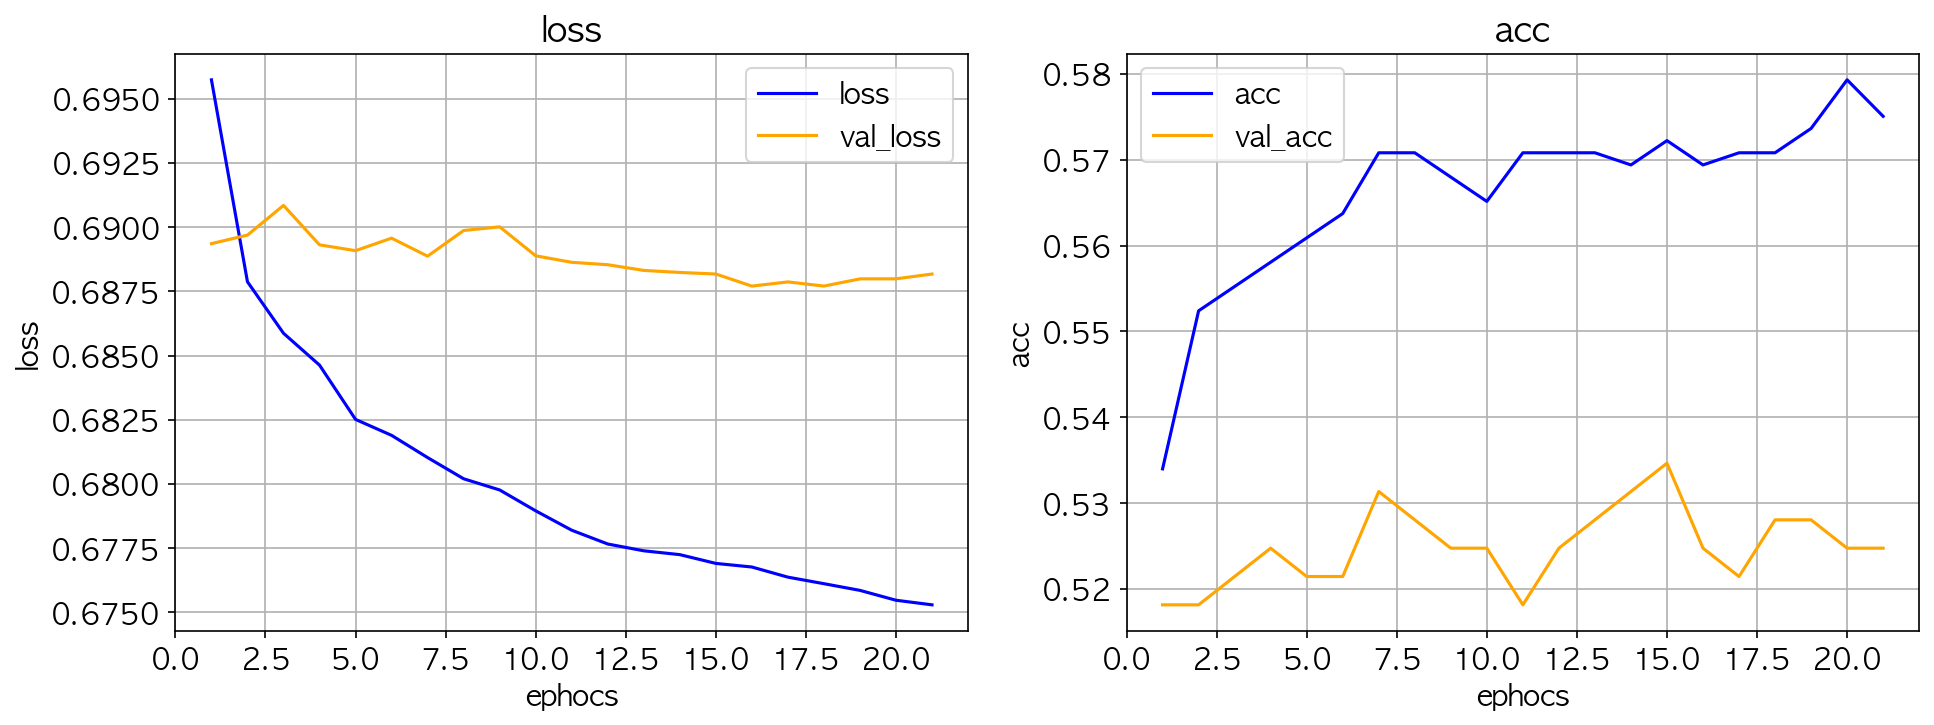

23/23 [==============================] - 0s 620us/step - loss: 0.6750 - acc: 0.5765
최종 훈련 손실룰: 0.674974, 최종 훈련 정확도: 0.576487
10/10 [==============================] - 0s 765us/step - loss: 0.6882 - acc: 0.5248
최종 검증 손실룰: 0.688174, 최종 검증 정확도: 0.524752


In [12]:
helper.tf_result_plot(result)

evaluate1 = my_model.evaluate(x_train, y_train)
print('최종 훈련 손실룰: %f, 최종 훈련 정확도: %f' % (evaluate1[0], evaluate1[1]))

evaluate2 = my_model.evaluate(x_test, y_test)
print('최종 검증 손실룰: %f, 최종 검증 정확도: %f' % (evaluate2[0], evaluate2[1]))

> 과적합 발생 확인
>
> 데이터의 수를 늘리거나 제약을 추가해줘야 함

In [13]:
logit_result = helper.tf_logit_result(my_model, result, x_train, y_train)

23/23 [==============================] - 0s 480us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                512       
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 577 (2.25 KB)
Trainable params: 577 (2.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
logit_result.cmdf

,Negative,Positive
True,370,277
False,22,37


In [15]:
helper.prettyPrint(logit_result.result_df.T)

+--------------------------+-----------+
|                          |         0 |
|--------------------------+-----------|
| 정확도(Accuracy)         |  0.576487 |
| 정밀도(Precision)        |  0.627119 |
| 재현율(Recall, TPR)      |  0.117834 |
| 위양성율(Fallout, FPR)   | 0.0561224 |
| 특이성(Specificity, TNR) |  0.943878 |
| RAS                      |  0.530856 |
| f1_score                 |  0.198391 |
+--------------------------+-----------+


> 정확도를 높이는 방법:
>
> 1) 처음부터 가능한 종속변수 모두를 분석하고 하나씩 제거하며 정확도를 비교해보는 방법
>
> 2) 처음에 최소한의 종속변수를 분석하고 하나씩 추가해가며 정확도를 비교해보는 방법
>
> 통계분석에서는 시간이 많이 안 걸리니까 1) 방법이 용이해보이고, 머신러닝에서는 시간이 오래걸리니까 2)이 용이해 보인다